## Design eines Linearbeschleunigers

Eckdaten des Beschleunigers:

$U(t) = U_0 \sin{\omega\cdot t}$

wobei

$U_0 = 100\text{kV} \\ \omega = 2\pi \cdot 200\text{MhZ}$

Die beschleunigten Teilchen sind Protonen mit einer Injektionsenergie von $E_k = 400\text{keV}$

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym
import pandas as pd

# die Energien werden in eV und die Ladung in einheiten der Elementarladung angegeben
e = 1
c = 299792458
m_p = 938_272_088 #eV
U_0 = 100_000 # V
E_0 = 400_000 # 400 KeV
omega = 2*np.pi*200_000_000 # 1/ns
periodenlaenge = 2*np.pi/omega


Da am anfang das Teilchen noch langsam ist, wird die Spaltbreite so auf die Teilchengeschwindigkeit angepasst dass das Teilchen waehrend der gesamten positiven halbwelle im Spalt ist.

Daher kann vereinfachend angenommen werden das das Teilchen waehrend der gesamten positiven Halbwelle beschleunigt wird. Da man die Beschleunigung kennt kann dann die Wegstrecke die das Teilchen waehrend der Beschleunigung zuruecklegt durch Integration finden. Dabei muessen relativistische Effekte beruecksichtigt werden.

$$ a = \frac{\mathrm{d}v}{\mathrm{d}t} = \frac{\mathrm{d}v}{\mathrm{d}E_k} \cdot \frac{\mathrm{d}E_k}{\mathrm{d}t}$$

Das Problem hier steckt in $\frac{\mathrm{d}E_k}{\mathrm{d}t}$ da $E_k$ von $v$ abhaengt, und wir damit so nicht weiterkommen.

Es ist allerdings moeglich das Problem in differnezialschreibweise zu formulieren. Es gelten die folgenden Zusammenhaenge:
$$ \beta = \frac{v}{c} = \sqrt{1 - \frac{1}{\gamma^2}} \\
\gamma = \frac{1}{\sqrt{1-\beta^2}} = \frac{E_0 + E_k}{E_0} \\
\mathrm{d}E_k = q\cdot U(t)\cdot v \mathrm{d}t \\
\mathrm{d}v = v_2 - v_1 = c\left(\sqrt{1-\frac{1}{\frac{E_2}{E_0}^2}}- \sqrt{1-\frac{1}{\frac{E_1}{E_0}^2}}\right) \\ = c \cdot \left(\sqrt{1-\frac{1}{\frac{E_1 + qU(t)v\mathrm{d}t}{E_0}^2}} - \sqrt{1-\frac{1}{\frac{E_1}{E_0}^2}}\right) 
$$

wobei $E_2 = E_1 + \mathrm{d}E$

Dieser Ausdruck mag analytisch nur schwer zu handhaben sein, ist in dieser Form allerdings bestens fuer die numerische Aufarbeitung geeignet, da er bereits in differentialform vorliegt und das Zeitverhalten (welches wir beobachten wollen) bereits explizit darin enthalten ist.
Es muss lediglich ein $v_0$ und ein $\mathrm{d}t$ gewaehlt werden um v(t) numerisch naehern zu koennen.

Es kann iterativ vorgegangen werden, was die obige formulierung nocheinmal vereinfacht

$$v_{n+1} = v_{n} + \mathrm{d}v = c\sqrt{1-\frac{1}{\frac{E_{n} + qU(t)v\mathrm{d}t}{E_0}^2}}$$

Es kann noch eine kleinigkeit optimiert werden, da $ U(t_n) \forall n$ bekannt ist kann anstelle von $U(t)$ hier $\frac{U(t_n) + U(t_n+1)}{2}$ eingesetzt werden

Um alles in eine Formel schreiben zu koennen, muss U(t) noch etwas modifiziert werden. Da das projektil die gesamte Zeit der negativen Halbwelle in der Driftroere ist, ist die auf das Teilchen wirkende Spannung hier lediglich 0.


In [16]:
import itertools as itt
def Voltage(t):
    a = U_0 * np.sin(omega*t)
    return a if a > 0 else 0

def average(f, t1, t2):
    return (f(t1)+f(t2))/2

def speed(E_k, E_ruhe):
    return c*np.sqrt(1-(1/((E_k+E_ruhe)/E_ruhe)**2))

def step(E, E_0, v, t, dt):
    E_new = E + average(Voltage, t, t+dt)*v*dt
    v_new = speed(E_new, E_0)
    ds = v*dt
    return E_new, v_new, ds, t+dt

def linac_sim_step(E, E_0, v, t, dt, end_time):
    s = 0
    while t < end_time:
        E, v, ds, t = step(E, E_0, v, t, dt)
        s += ds
        yield E, v, s, t

def get_data_after_period(iterator, timeindex, period):
    buffer = [0, 0, 0]
    for elem in iterator:
        buffer[2] = buffer[1]
        buffer[1] = buffer[0]
        buffer[0] = elem[timeindex] % period
        if buffer[2] > buffer[1] and buffer[0] > buffer[1]:
            yield last_elem
        last_elem = elem

def get_tube_and_slot_lengths(iterator):
    tube_lengths = []
    slot_lengths = []
    tube_start = 0
    tube_end = 0
    slot_start = 0
    slot_end = 0
    for i, elem in enumerate(iterator):
        if i % 2 == 0:
            tube_end = elem[3]
            slot_start = elem[3]
            tube_lengths.append(tube_end - tube_start)
        else:
            tube_start = elem[3]
            slot_end = elem[3]
            slot_lengths.append(slot_end - slot_start)
    return slot_lengths, tube_lengths

def get_first_n_vals(iterator, n):
    first_n_vals = []
    for i, elem in enumerate(iterator):
        if i < n:
            first_n_vals.append(elem)
        else:
            return first_n_vals

def print_progress(line, i, total_line_cnt):
    if i % int(total_line_cnt/1000) == 0:
        print("Current read completion: {:.3f}%".format((i*100)/total_line_cnt), end='\r')

def to_numerical_vals(line):
    return [float(n) for n in line.split(',')]

In [ ]:
# build filter chain for the readout of the values from a file
f = open("beschleuniger_run_proton_data.dat", "r")
header = f.readline()
nv = map(to_numerical_vals, f)
sl, tl = get_tube_and_slot_lengths(get_data_after_period(nv, 0, periodenlaenge))

In [31]:
f.seek(0)
f.readline()
nv = map(to_numerical_vals, f)
first_10000_samples = get_first_n_vals(nv, 10000000)

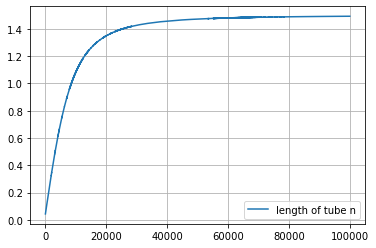

In [40]:
plt.grid()
plt.plot(tl[:100000], label="length of tube n")
plt.legend()
plt.show()
#plt.plot(sl)
#plot_t = [elem[0] for elem in periodic_data_sample]
#plot_s = [elem[3] for elem in periodic_data_sample]
#plt.plot(plot_t,plot_s

In [36]:
t, E, v, s, U = zip(*first_10000_samples)

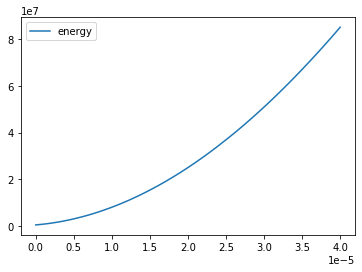

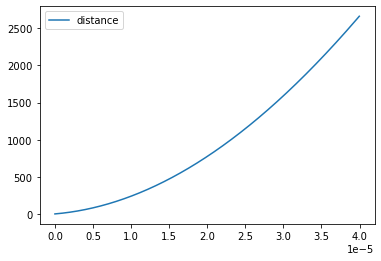

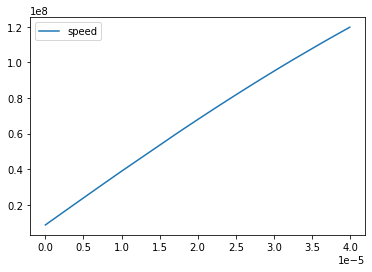

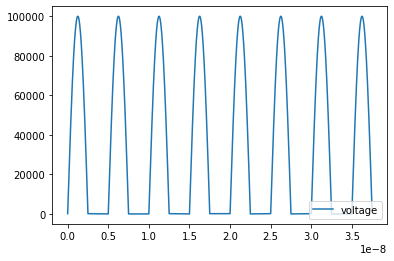

In [37]:
plt.plot(t[::1000], E[::1000], label="energy")
plt.grid()
plt.legend()
plt.show()
plt.plot(t[::1000], s[::1000], label="distance")
plt.grid()
plt.legend()
plt.show()
plt.plot(t[::1000], v[::1000], label="speed")
plt.grid()
plt.legend()
plt.show()
plt.plot(t[:1000], U[:10000], label="voltage")
plt.legend()
plt.grid()
plt.show()

In [34]:
end_time = 1*10**-6# end time in s
dt = 1/500*10**-9 # 500 schritte pro nanosekunde
# initialize the variables
t = 0
E_k = E_0
v = speed(E_0, m_p)
s = 0

# check values to be sane
print("Initial Speed: {:.3f} m/s".format(v))
print("Initial Energy: {:.3f} eV".format(E_k))

Initial Speed: 8751096.493 m/s
Initial Energy: 400000.000 eV


In [35]:
storage_file = input("Filename:")
# be sure to write the data to a file so that the whole thing does not have to
# run over and over (a single run for 1 ms takes about 2 hours)
halfwav_dist = []
if calculate:
    with open(storage_file, 'w+') as output:
        # write the first line with the variable names
        output.write("time[s],energy[eV],speed[m/s],traveled_dist[m],Voltage[V]\n")
        while t <= end_time:
            output.write("{:.12f},{:.0f},{:.6f},{:.6f},{:.3f}\n".format(t,E_k,v,s,average(Voltage, t, t+dt)))
            E_k, v, ds, t = step(v, E_k, t, dt, Voltage, m_p)
            s += ds
            if t % periodenlaenge <= 1.1*dt:
                print("t: {:.12f}".format(t))
                print("s: {:.9f}".format(s))

KeyboardInterrupt: Interrupted by user